In [2]:
import os, shutil, random
from types import SimpleNamespace
from pathlib import Path
import zipfile
import torch
import wandb
import torchvision
import torchvision.transforms as T
from PIL import Image
from fastdownload import FastDownload
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

In [3]:
def set_seed(s, reproducible=False):
    "Set random seed for `random`, `torch`, and `numpy` (where available)"
    try: torch.manual_seed(s)
    except NameError: pass
    try: torch.cuda.manual_seed_all(s)
    except NameError: pass
    try: np.random.seed(s%(2**32-1))
    except NameError: pass
    random.seed(s)
    if reproducible:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [4]:
def untar_data(url, force_download=False, base='./datasets'):
    d = FastDownload(base=base)
    return d.get(url, force=force_download, extract_key='data')

In [5]:
cifar_labels = "airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck".split(",")

In [6]:
def get_cifar(cifar100=False, img_size=32):
    "Download and extract CIFAR"
    cifar10_url = 'https://s3.amazonaws.com/fast-ai-sample/cifar10.tgz'
    cifar100_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar100.tgz'
    return untar_data(cifar100_url if cifar100 else cifar10_url)


In [7]:
path = get_cifar()

In [8]:
at = wandb.Artifact("CIFAR10-32", type="dataset", 
                    description="The CIFAR10 datasets scaled to 32 pixels",  
                    metadata={"img_size":32, 
                              "labels":cifar_labels})

In [9]:
at.add_dir("datasets/data/cifar10")

wandb: Adding directory to artifact (.\datasets\data\cifar10)... Done. 55.2s


In [ ]:
# with wandb.init(project="train_sd", job_type="log_dataset"):
#     wandb.log_artifact(at)

In [10]:
def get_cifar_data(dataset_path, img_size=32, batch_size=8, train_folder="train", val_folder="test", slice_size=-1, num_workers=4):
    train_transforms = torchvision.transforms.Compose([
        T.Resize(img_size + int(.25*img_size)),  # img_size + 1/4 *img_size
        T.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    val_transforms = torchvision.transforms.Compose([
        T.Resize(img_size),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    train_dataset = torchvision.datasets.ImageFolder(os.path.join(dataset_path, train_folder), transform=train_transforms)
    val_dataset = torchvision.datasets.ImageFolder(os.path.join(dataset_path, val_folder), transform=val_transforms)
    
    if slice_size>1:
        train_dataset = torch.utils.data.Subset(train_dataset, indices=range(0, len(train_dataset), slice_size))
        val_dataset = torch.utils.data.Subset(val_dataset, indices=range(0, len(val_dataset), slice_size))

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_dataset = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_dataloader, val_dataset

In [11]:
train_dl, val_dl = get_cifar_data(path, batch_size=256, slice_size=100)

In [12]:
train_batch = next(iter(train_dl))

In [13]:
x, y = train_batch

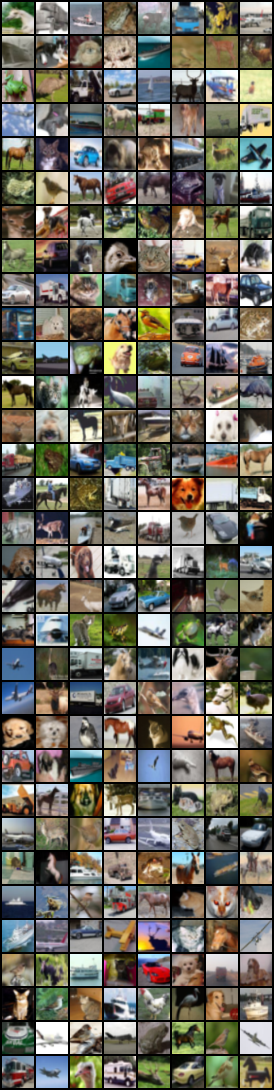

In [14]:
wandb.Image(x).image

In [15]:
table = wandb.Table(columns=["image", "label_id", "label", "split"])

In [16]:
for img, label in iter(train_dl.dataset):
    table.add_data(wandb.Image(img), label, cifar_labels[label], "train")

In [17]:
for img, label in iter(val_dl.dataset):
    table.add_data(wandb.Image(img), label, cifar_labels[label], "valid")

In [18]:
# with wandb.init(project="train_sd", group="cifar10", job_type="dataset_viz"):
#     wandb.use_artifact('mobilediff/train_sd/CIFAR10-32:v0', type='dataset')
#     wandb.log({"cifar_viz":table})

In [19]:
from ddpm_conditional import *

In [20]:
config.noise_steps = 100
config.epochs = 1000
config.slice_size = 100
config.use_wandb = True
config.dataset_artifact = 'mobilediff/train_sd/CIFAR10-32:v0'
config.log_every_epoch = 5

In [21]:
diff = Diffusion(noise_steps=config.noise_steps, img_size=32, num_classes=10)

wandb: Currently logged in as: skng (mobilediff). Use `wandb login --relogin` to force relogin


02:52:24 - INFO: Starting epoch 0:


02:52:55 - INFO: Sampling 10 new images....


02:52:57 - INFO: Sampling 10 new images....


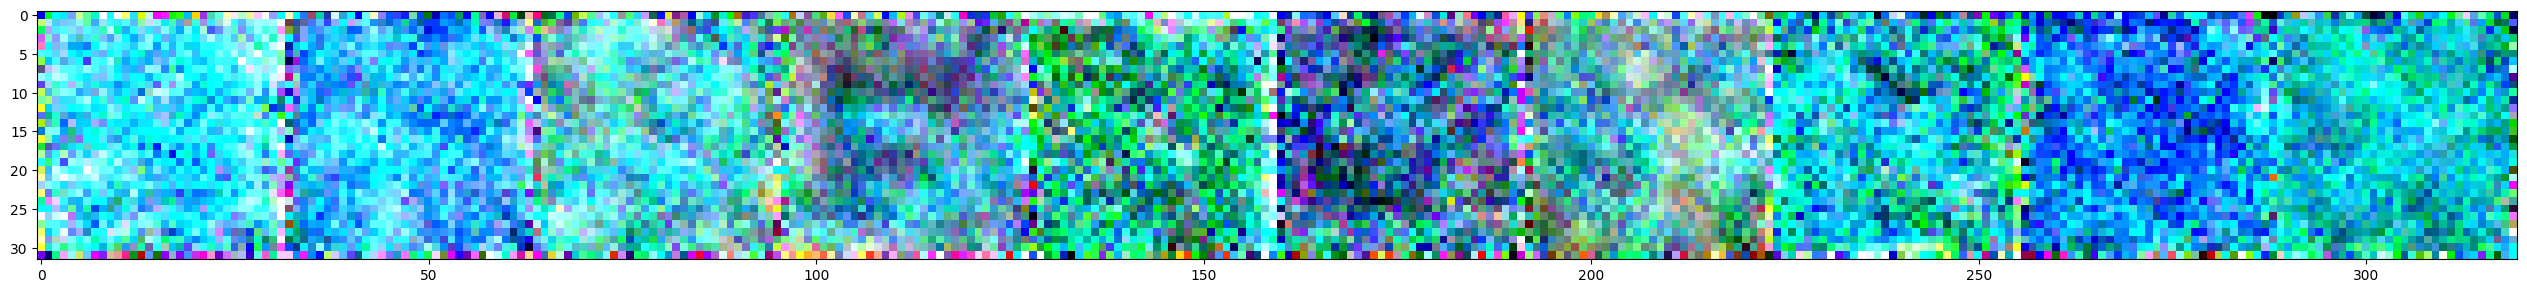

02:52:59 - INFO: Starting epoch 1:


02:53:29 - INFO: Starting epoch 2:


02:53:59 - INFO: Starting epoch 3:


02:54:29 - INFO: Starting epoch 4:


02:54:59 - INFO: Starting epoch 5:


In [22]:
with wandb.init(project="train_sd", group="train", config=config):
    wandb.use_artifact(config.dataset_artifact, type='dataset')
    diff.prepare(config)
    diff.fit(config)